# Stock Price

It is a time-series project that aims to forecast future stock prices based on patterns and behavior of the past market data.

In [ ]:
import seaborn
import matplotlib
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

%matplotlib inline

In [2]:
# Market Data
STOCK_NAME = "SISE.IS"
STOCK_HISTORY = "2y"

# Estimation
FORECAST_PERIOD = 30
TRAIN_PERIOD = None  # Dynamically set later

# Cross Validation
CV_HISTORY = "1y"
CV_PERIOD = "30 days"
CV_HORIZON = "60 days"

### DATA

In [3]:
ticker = yf.Ticker(STOCK_NAME)
historical_data = ticker.history(
    period=STOCK_HISTORY, 
    actions=False
)

In [4]:
historical_data.reset_index(inplace=True)

historical_data.head(7)

,Date,Open,High,Low,Close,Volume
0,2020-10-14,6.492567,6.559797,6.463754,6.492567,135856446
1,2020-10-15,6.482962,6.569402,6.454149,6.473358,108023547
2,2020-10-16,6.473358,6.569402,6.463753,6.511775,176393050
3,2020-10-19,6.540589,6.607819,6.530984,6.588611,152234088
4,2020-10-20,6.607819,6.723072,6.550193,6.703863,281887850
5,2020-10-21,6.723072,6.780698,6.675050,6.694259,153400077
6,2020-10-22,6.684654,6.694259,6.579006,6.588611,143443041


In [5]:
historical_data.describe()["Close"]

count    502.000000
mean      12.570567
std        6.581724
min        5.897094
25%        7.368967
50%        8.570650
75%       16.994206
max       30.040001
Name: Close, dtype: float64

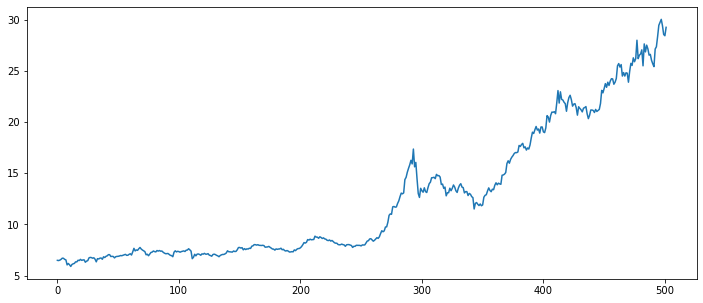

In [6]:
historical_data["Close"].plot(figsize=(12, 5))

plt.savefig("out/stock_price.png")

In [7]:
df = historical_data[["Date", "Close", "Volume"]]
df = df.rename(columns={"Date": "ds", "Close": "y"})

df.head(7)

,ds,y,Volume
0,2020-10-14,6.492567,135856446
1,2020-10-15,6.473358,108023547
2,2020-10-16,6.511775,176393050
3,2020-10-19,6.588611,152234088
4,2020-10-20,6.703863,281887850
5,2020-10-21,6.694259,153400077
6,2020-10-22,6.588611,143443041


In [8]:
TRAIN_PERIOD = int(df.shape[0] - FORECAST_PERIOD)

df_train, df_test = df[:TRAIN_PERIOD], df[TRAIN_PERIOD:]

### MODEL

In [9]:
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

In [10]:
model.add_regressor("Volume")
model.add_country_holidays(country_name="TR")

In [11]:
model.fit(df_train)

16:05:31 - cmdstanpy - INFO - Chain [1] start processing
16:05:31 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
df_forecast = df_test[["ds", "Volume"]].copy()  # model.make_future_dataframe(periods=FORECAST_PERIOD)

### RESULT

In [13]:
df_forecast = model.predict(df_forecast)

df_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(7)

,ds,yhat,yhat_lower,yhat_upper
23,2022-10-06,27.987100,26.762962,28.995165
24,2022-10-07,27.938415,26.728119,28.976399
25,2022-10-10,27.789669,26.536514,28.877526
26,2022-10-11,27.773720,26.720668,28.849884
27,2022-10-12,27.932780,26.806460,29.066247
28,2022-10-13,27.920342,26.818927,29.055038
29,2022-10-14,28.058834,26.874031,29.117830


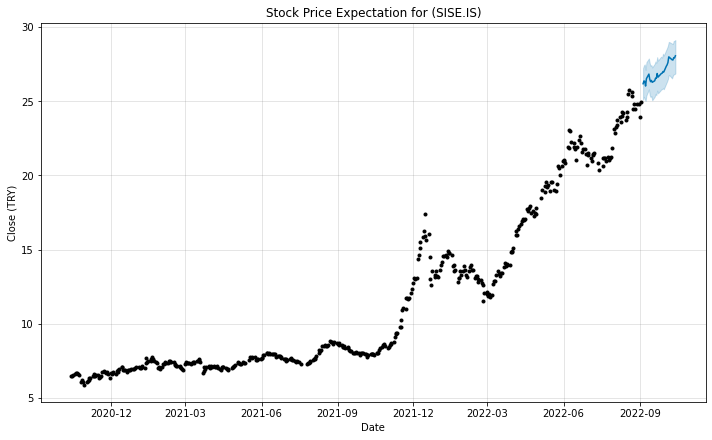

In [14]:
model.plot(df_forecast)

plt.title("Stock Price Expectation for ({})".format(STOCK_NAME))
plt.xlabel("Date")
plt.ylabel("Close (TRY)")
plt.show()

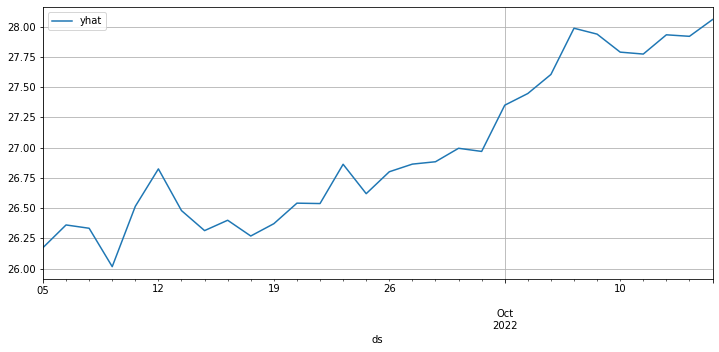

In [15]:
df_forecast.plot(
    x="ds", 
    y="yhat", 
    grid=True, 
    figsize=(12, 5)
)

plt.savefig("out/stock_price_forecast.png")

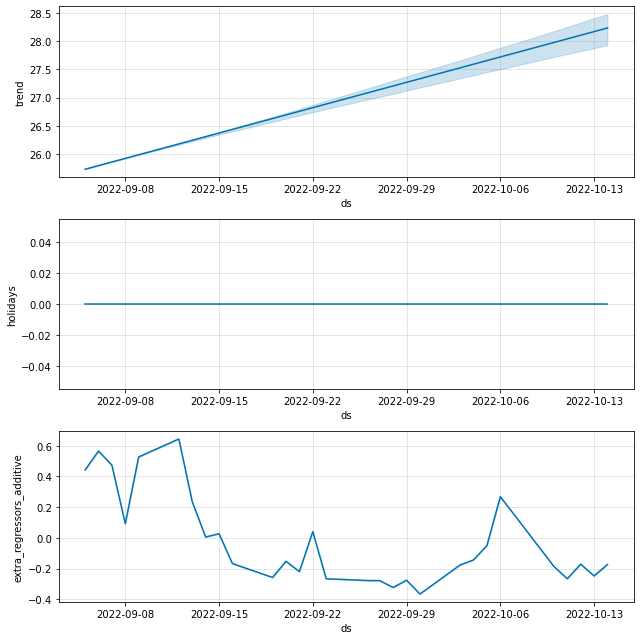

In [16]:
model.plot_components(df_forecast)

plt.show()

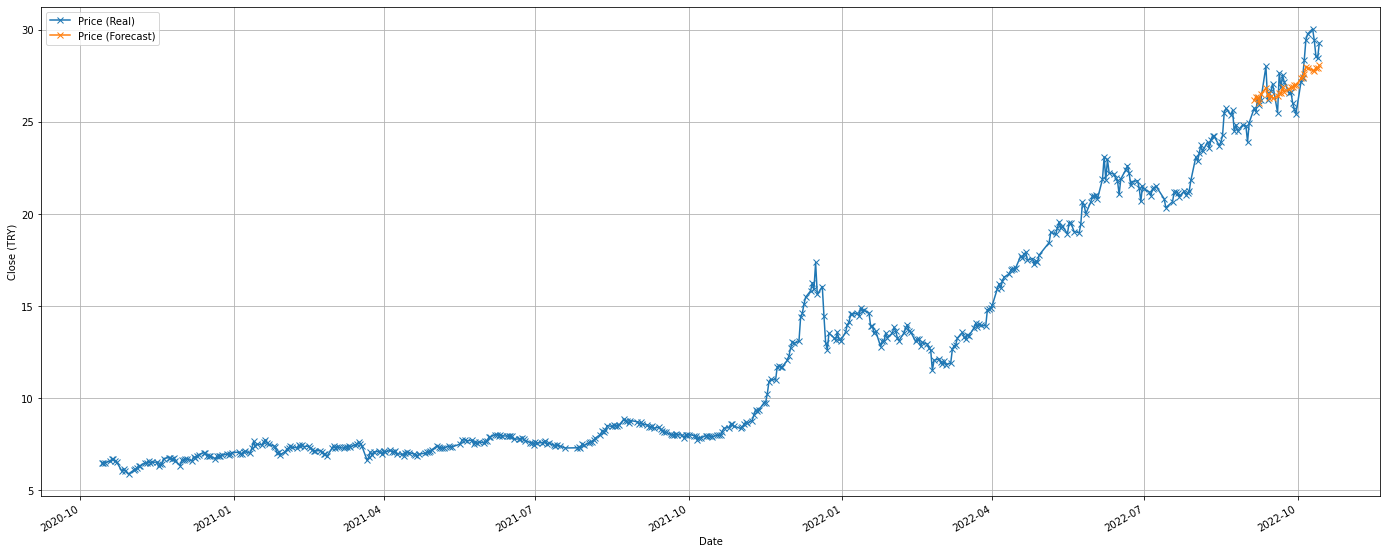

In [17]:
ax = df.plot(
    x="ds", 
    y="y", 
    style="x-", 
    grid=True,
    figsize=(24, 10)
)
ax.plot(
    df["ds"][TRAIN_PERIOD:], 
    df_forecast["yhat"], 
    marker="x"
)

ax.set_xlabel("Date")
ax.set_ylabel("Close (TRY)")
ax.legend(["Price (Real)", "Price (Forecast)"])

plt.savefig("out/stock_price_comparison.png")

### EVALUATION

In [ ]:
cv = cross_validation(
    model, 
    initial=CV_HISTORY, 
    period=CV_PERIOD, 
    horizon=CV_HORIZON, 
    parallel="processes"
)

In [19]:
cv_performance = performance_metrics(
    cv, 
    rolling_window=1
)

cv_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,60 days,12.039894,3.469855,2.98723,0.188928,0.165579,0.195607,0.147849


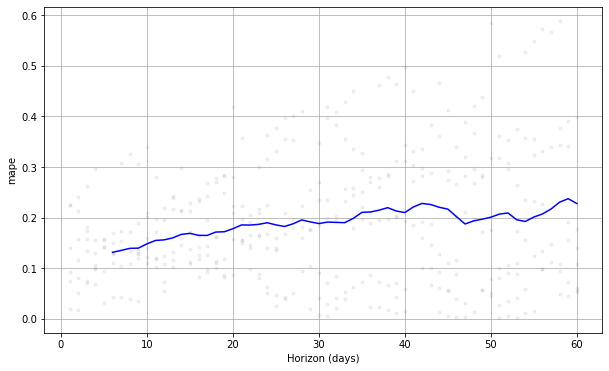

In [23]:
plot_cross_validation_metric(
    cv, 
    metric="mape"
)

plt.show()